In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

if False:
    import os
    # Turn off GPU
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    gpu = False
else:
    gpu = True

import pandas as pd
import matplotlib.pyplot as plt
from utils.model_utils import lastLayerToArgMax
from utils import data_utils
import tensorflow as tf
from glob import glob
import numpy as np
import models
import cv2
import os

gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus)

if gpu:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024 * 2))])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
DATA_DIR = "utils/split_3/_split_/_type_"
imageSize = (240, 320)

train_X = sorted(glob(DATA_DIR.replace("_split_", "TrainVal").replace("_type_", "img") + "\\*"))
train_Y = sorted(glob(DATA_DIR.replace("_split_", "TrainVal").replace("_type_", "mask") + "\\*"))

train_data = data_utils.load_dataset(train_X, train_Y, IMAGE_SIZE=imageSize, BATCH_SIZE=1)

test_X = sorted(glob(DATA_DIR.replace("_split_", "test").replace("_type_", "img") + "\\*"))
test_Y = sorted(glob(DATA_DIR.replace("_split_", "test").replace("_type_", "mask") + "\\*"))

test_data = data_utils.load_testset(test_X, test_Y, IMAGE_SIZE=imageSize, BATCH_SIZE=1, REMAP="binary")

In [3]:
modelFolder = "model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True/*/*/*/*/*"
print(modelFolder)

modelsList = sorted(glob(modelFolder + "/*.ckpt"))
print(modelsList)

modelsCommonName = "DeeplabV3Plus_MobileNetV2"
print(modelsCommonName)

model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True/*/*/*/*/*
['model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.0001\\0.ckpt', 'model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.0001\\1.ckpt', 'model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.0001\\2.ckpt', 'model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.0001\\3.ckpt', 'model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.0001\\4.ckpt']
DeeplabV3Plus_MobileNetV2


In [4]:

class Metrics():
    def __init__(self, modelsPath : list, folds : int = 5):
        self.folds = folds
        self.modelsPath = modelsPath
        self.__getAllMetrics__()
    
    def __getAllMetrics__(self):
        modelsDictDF = {}

        for i, model in enumerate(self.modelsPath):
            modelsDictDF[i] = {}
            modelsDictDF[i] = pd.read_csv(model.replace(".ckpt", ".csv"))

        self.__allMetrics = modelsDictDF
    
    def get(self):
        return self.__allMetrics
    
    def __createFig__(self, figName: str):
        ncolumns = self.folds

        fig, axes = plt.subplots(
            nrows=1, ncols=ncolumns, sharey='row')
        fig.suptitle(figName)
        fig.set_figheight(4.5)
        fig.set_figwidth(20)

        return fig, axes
    
    def __getTopNBottom__(self, minMetric: str, lookMetric: str):
        y_top_lim = -1
        y_bottom_lim = 9999

        for i, key in enumerate(self.__allMetrics.keys()):
            idx = self.__allMetrics[key][minMetric].idxmin()
            val_loss = self.__allMetrics[key][lookMetric].iloc[idx]

            if y_top_lim < val_loss:
                y_top_lim = val_loss

            if y_bottom_lim > val_loss:
                y_bottom_lim = val_loss

        y_top_lim    += 0.1
        y_bottom_lim -= 0.1

        if y_top_lim >= 1.:
            y_top_lim = 1.
        if y_bottom_lim <= 0.:
            y_bottom_lim = 0.
    
        return y_top_lim, y_bottom_lim

    def plotMetric(
            self, modelName: str = "model", minMetric: str = "val_loss",
            lookMetric: str = "val_loss", save: bool = False):

        if lookMetric.find("val_") == -1:
            trainMetric = lookMetric
            valMetric = "val_" + lookMetric
        else:
            trainMetric = lookMetric.replace("val_", "")
            valMetric = lookMetric

        fig, axes = self.__createFig__(modelName)
        y_top_lim, y_bottom_lim = self.__getTopNBottom__(minMetric, lookMetric)

        for i, key in enumerate(self.__allMetrics.keys()):
            min_index_aux = self.__allMetrics[key][minMetric].idxmin()

            metric = self.__allMetrics[key][trainMetric]
            val_metric = self.__allMetrics[key][valMetric]

            print(key)
            print(trainMetric + ":",   metric.iloc[min_index_aux])
            print(valMetric + ":", val_metric.iloc[min_index_aux])

            axes[i].axhline(
                val_metric.iloc[min_index_aux], linestyle="--", color='r',
                linewidth=0.75)
            axes[i].axvline(
                min_index_aux, linestyle="--", color='r', linewidth=0.75)

            axes[i].set_xlim(left=0, right=100)
            axes[i].set_ylim(bottom=y_bottom_lim, top=y_top_lim)

            metric.plot(ax=axes[i], legend=True, fontsize=10)
            val_metric.plot(ax=axes[i], legend=True, title=key, fontsize=10)

        if save:
            fig.savefig(f"{modelName}_{trainMetric}.png")

0
loss: 0.0220556147396564
val_loss: 0.0247567053884267
1
loss: 0.0221533216536045
val_loss: 0.0242058578878641
2
loss: 0.0221717208623886
val_loss: 0.0244481954723596
3
loss: 0.0222094897180795
val_loss: 0.0242196470499038
4
loss: 0.0222837105393409
val_loss: 0.0243932139128446


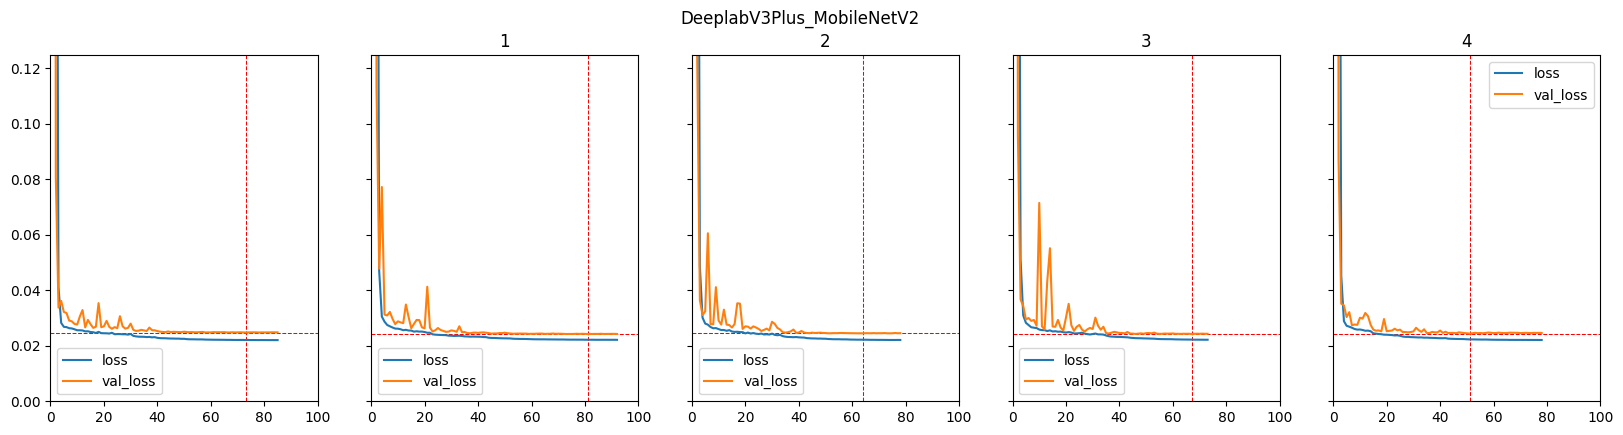

In [5]:
Metrics(modelsList, 5).plotMetric(
    modelName=modelsCommonName, minMetric="val_loss", lookMetric="val_loss", save=True)

0
dice_coef: 0.9536307454109192
val_dice_coef: 0.9472219944000244
1
dice_coef: 0.9534047245979308
val_dice_coef: 0.9488874673843384
2
dice_coef: 0.9534920454025269
val_dice_coef: 0.947962999343872
3
dice_coef: 0.9533202052116394
val_dice_coef: 0.9484955668449402
4
dice_coef: 0.9531766772270204
val_dice_coef: 0.948883891105652


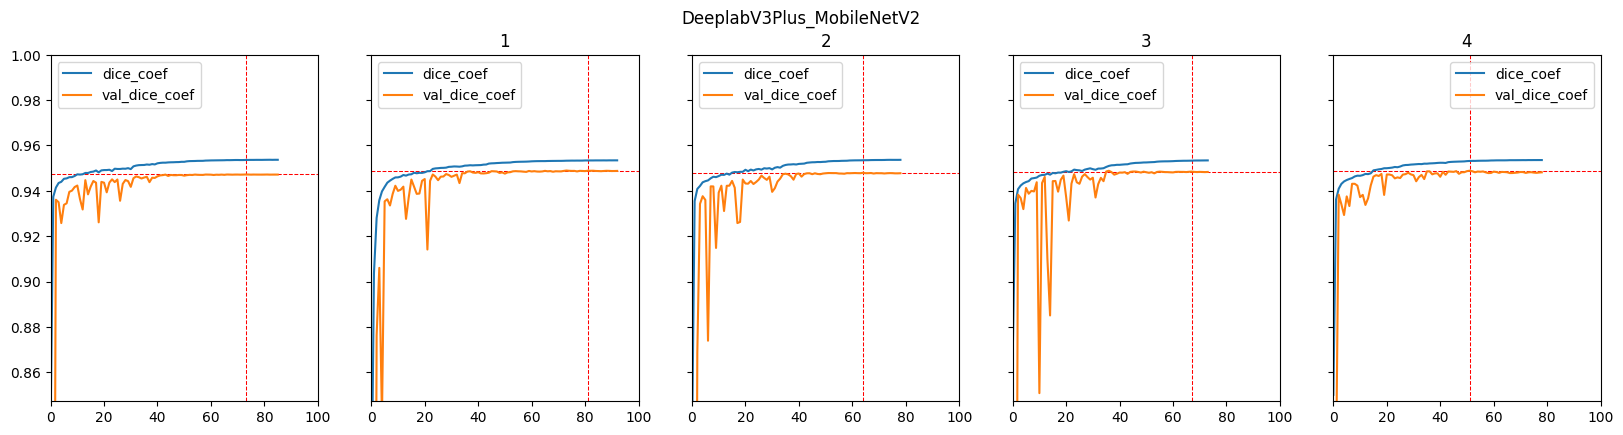

In [6]:
Metrics(modelsList, 5).plotMetric(
    modelName=modelsCommonName, minMetric="val_loss", lookMetric="val_dice_coef", save=True)

In [5]:
import numpy as np
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def confusion_matrix(y_true, y_pred):
    # True positive 1 & 1
    TP = np.bitwise_and(
        (y_true == 1), (y_pred == 1)).sum()
    # False positive 0 & 1
    FP = np.bitwise_and(
        (y_true == 0), (y_pred == 1)).sum()
    # True negative 0 & 0
    TN = np.bitwise_and(
        (y_true == 0), (y_pred == 0)).sum()
    # False negative 1 & 0
    FN = np.bitwise_and(
        (y_true == 1), (y_pred == 0)).sum()

    output = np.array([[TN, FP], [FN, TP]])

    return output, output.sum()

def run_confusion_matrix(y_pred, dataset, normalize=False, imageSize=(240, 320)):
    BATCH = IMG = 0
    MASK = 1

    matrix = np.array([[0, 0], [0, 0]])
    total = 0

    for i in range(len(dataset)):
        _, y_true, _ = dataset.__getitem__(i)
        y_true = y_true.reshape(imageSize)[0]
        matrixPartial, totalPartial = confusion_matrix(y_true, y_pred[i])

        matrix += matrixPartial
        total += totalPartial

    if normalize:
        matrix = matrix / total
    
    return matrix.tolist()

def mIOU(y_true, y_pred, n_classes=None):
    ulabels = np.unique(y_pred)

    if n_classes != None:
        y_pred[y_true >= n_classes] = n_classes

    iou = np.zeros(len(ulabels), dtype=np.float32)

    for k, u in enumerate(ulabels):
        inter = (y_true == u) & (y_pred == u)
        union = (y_true == u) | (y_pred == u)

        iou[k] = inter.sum() / union.sum()

    return iou.mean()

def run_mIOU(model, dataset, imageSize=(1, 240, 320), n_classes=None):
    mIOUList = []

    for idx in range(len(dataset)):
        img, y_true, _ = dataset.__getitem__(idx)
        y_true = y_true.reshape(imageSize)[0].astype(np.uint8)
        y_pred = model.predict(img, verbose=0)[0].astype(np.uint8)

        mIOUList.append(mIOU(y_true, y_pred, n_classes))

    mIOUList = np.array(mIOUList, dtype=np.float32)
    mean = mIOUList.mean().round(4)
    std = mIOUList.std().round(4)

    return mIOUList.round(2), mean, std

class plot_distribution():
    def __init__(self):
        self.plot_name = ""
        self.data = {}

    def set_name(self, plot_name: str):
        self.plot_name = plot_name

    def add_data(self, name: str, data: list):
        self.data[name] = data

    def show_plot(self, save: bool = False):
        assert self.data.__len__() != 0, "No data"

        fig, ax = plt.subplots()
        ax.set_title(self.plot_name)
        
        sns.set_context("paper")
        
        ax.set_xlabel("mIOU")
        ax.set_ylabel("mIOU frequency")

        ax = sns.histplot(data=self.data, legend=True, kde=True, 
                          common_norm=False, stat="count", ax=ax,
                          palette=sns.color_palette(n_colors=len(self.data)))

        if save:
            saveName = self.plot_name.replace(" ", "_")
            fig.savefig(f"metrics/{saveName}.svg", format="svg")

        plt.show()
    
    def clear(self):
        self.plot_name = ""
        self.data = {}
    
plotter = plot_distribution()

In [6]:
modelsList, modelsCommonName

(['model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.0001\\0.ckpt',
  'model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.0001\\1.ckpt',
  'model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.0001\\2.ckpt',
  'model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.0001\\3.ckpt',
  'model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.0001\\4.ckpt'],
 'DeeplabV3Plus_MobileNetV2')

In [7]:
BATCH_SIZE = 1
SEED = 42
n_classes = 2

split = modelsList[0].replace("/", "\\").split("\\")

modellayer, modelAlpha = split[5].replace("layer_", ""), float(split[6].replace("alpha_", ""))
TEST = split[4] == "True"
print(modellayer, modelAlpha)

mobileLayers = {
    "shallowLayer": "block_2_project_BN",
    "deepLayer": f"block_{modellayer}_project_BN"}


12 0.5


In [10]:
folderSave = f"metrics/kfold_{modelsCommonName}_{TEST.__str__()}_metrics_val.csv"
with open(folderSave, "w") as f:
    f.write("fold,train_mean,train_std,val_mean,val_std\n")

modelValResult = dict()

train_val_folds = data_utils.load_datasetCV(
    train_X, train_Y, IMAGE_SIZE=imageSize, BATCH_SIZE=BATCH_SIZE, REMAP="binary",
    N_FOLDS=5, SEED=SEED)

print(modelsCommonName)

for fold, (modelFolder, (trainDataset, valDataset, n_classes)) in enumerate(zip(modelsList, train_val_folds)):
    modelValResult[fold] = dict()
    print(f"loading model {fold}")

    model = models.deeplabV3(
        imageSize=imageSize, nClasses=n_classes, alpha=modelAlpha, withArgmax=True, mobileLayers=mobileLayers, TEST=TEST)
    model.load_weights(modelFolder)
    print(modelFolder)

    print("Running train")
    _mIOU, train_mean, train_std = run_mIOU(model, trainDataset)
    modelValResult[fold]["train"] = _mIOU.tolist()

    print("Running validation")
    _mIOU, val_mean, val_std = run_mIOU(model, valDataset)
    modelValResult[fold]["validation"] = _mIOU.tolist()

    with open(folderSave, "a") as f:
        f.write(f"{fold},{train_mean:.4f},{train_std:.4f},{val_mean:.4f},{val_std:.4f}\n")

DeeplabV3Plus_MobileNetV2
loading model 0


d:\Anaconda\envs\tf-gpu\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\layer_12\alpha_0.5\loss_dice_coef\l1_1e-06\l2_0.0001\0.ckpt
Running train
Running validation
loading model 1
model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\layer_12\alpha_0.5\loss_dice_coef\l1_1e-06\l2_0.0001\1.ckpt
Running train
Running validation
loading model 2
model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\layer_12\alpha_0.5\loss_dice_coef\l1_1e-06\l2_0.0001\2.ckpt
Running train
Running validation
loading model 3
model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\layer_12\alpha_0.5\loss_dice_coef\l1_1e-06\l2_0.0001\3.ckpt
Running train
Running validation
loading model 4
model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\layer_12\alpha_0.5\loss_dice_coef\l1_1e-06\l2_0.0001\4.ckpt
Running train
Running validation


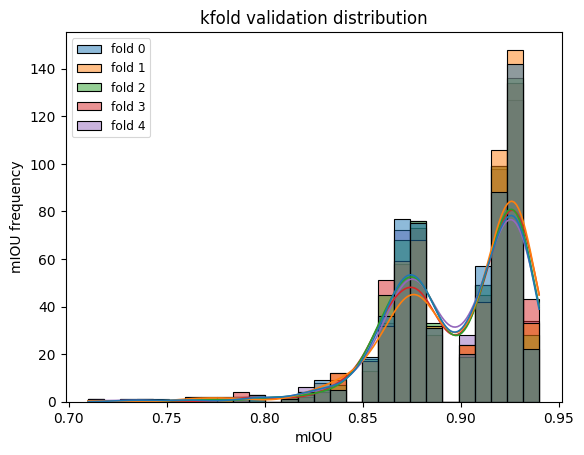

In [11]:
plotter.set_name("kfold validation distribution")

for key in modelValResult.keys():
    plotter.add_data(f"fold {key}", modelValResult[key]["validation"])

plotter.show_plot(save=True)

plotter.clear()

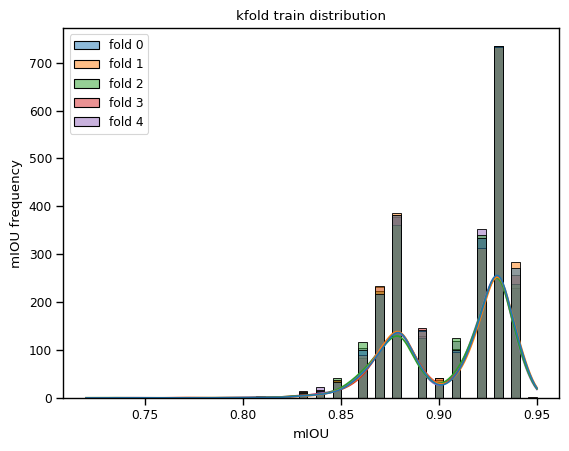

In [12]:
plotter.set_name("kfold train distribution")

for key in modelValResult.keys():
    plotter.add_data(f"fold {key}", modelValResult[key]["train"])

plotter.show_plot(save=True)

plotter.clear()

TEST FOLDS IN TESTSET

In [13]:
folderSave = f"metrics/kfold_{modelsCommonName}_{TEST.__str__()}_metrics_test.csv"

with open(folderSave, "w") as f:
    f.write("fold,mean,std\n")

modelTestResult = {}

for fold, modelFolder in enumerate(modelsList):
    print(modelFolder)

    model = models.deeplabV3(imageSize=imageSize, nClasses=n_classes, alpha=modelAlpha, withArgmax=True, mobileLayers=mobileLayers, TEST=TEST)
    model.load_weights(modelFolder)

    _mIOU, mean, std = run_mIOU(model, test_data)
    modelTestResult[fold] = _mIOU.round(2).tolist()

    with open(folderSave, "a") as f:
        f.write(f"{fold},{mean:.4f},{std:.4f}\n")

model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\layer_12\alpha_0.5\loss_dice_coef\l1_1e-06\l2_0.0001\0.ckpt


d:\Anaconda\envs\tf-gpu\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\layer_12\alpha_0.5\loss_dice_coef\l1_1e-06\l2_0.0001\1.ckpt
model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\layer_12\alpha_0.5\loss_dice_coef\l1_1e-06\l2_0.0001\2.ckpt
model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\layer_12\alpha_0.5\loss_dice_coef\l1_1e-06\l2_0.0001\3.ckpt
model-saved/deeplabV3+_mobileNetV2/NEW_3/kfold/True\layer_12\alpha_0.5\loss_dice_coef\l1_1e-06\l2_0.0001\4.ckpt


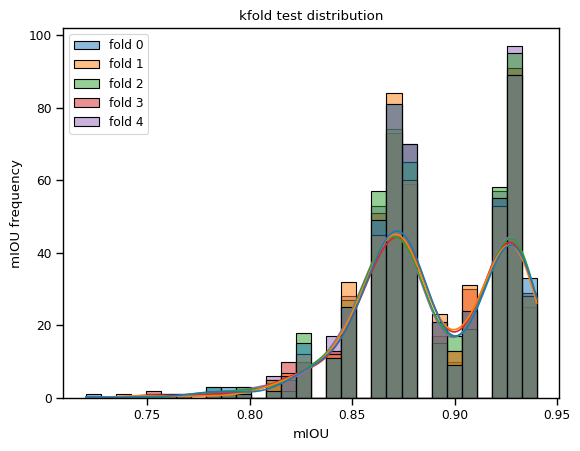

In [14]:
plotter.set_name("kfold test distribution")

for key in modelTestResult.keys():
    plotter.add_data(f"fold {key}", modelTestResult[key])

plotter.show_plot(save=True)

plotter.clear()

In [15]:
gridsearch_models = sorted(glob("model-saved/deeplabV3+_mobileNetV2/NEW_3/GRID_SEARCH/*/*/*/*/*/*/*ckpt"))
gridsearch_models, len(gridsearch_models)

(['model-saved/deeplabV3+_mobileNetV2/NEW_3/GRID_SEARCH\\False\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.0001\\grid_search.ckpt',
  'model-saved/deeplabV3+_mobileNetV2/NEW_3/GRID_SEARCH\\False\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.001\\grid_search.ckpt',
  'model-saved/deeplabV3+_mobileNetV2/NEW_3/GRID_SEARCH\\False\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.01\\grid_search.ckpt',
  'model-saved/deeplabV3+_mobileNetV2/NEW_3/GRID_SEARCH\\False\\layer_12\\alpha_0.5\\loss_iou_coef\\l1_1e-06\\l2_0.0001\\grid_search.ckpt',
  'model-saved/deeplabV3+_mobileNetV2/NEW_3/GRID_SEARCH\\False\\layer_12\\alpha_0.5\\loss_iou_coef\\l1_1e-06\\l2_0.001\\grid_search.ckpt',
  'model-saved/deeplabV3+_mobileNetV2/NEW_3/GRID_SEARCH\\False\\layer_12\\alpha_0.5\\loss_iou_coef\\l1_1e-06\\l2_0.01\\grid_search.ckpt',
  'model-saved/deeplabV3+_mobileNetV2/NEW_3/GRID_SEARCH\\True\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.0001\\grid_search.ckpt',
  'model-saved/deeplabV

In [16]:
folder = f"metrics/grid_search_test.csv"

with open(folder, "w") as f:
    f.write("loss,l2,train_mean,train_std,val_mean,val_std\n")

for i, modelPath in enumerate(gridsearch_models):
    print(f"{i+1} of {len(gridsearch_models)}")

    modelSplit = modelPath.replace("\\", "/").split("/")

    
    TEST =        modelSplit[4] == "True"
    deeplayer =   modelSplit[5].replace("layer_", "")
    alpha = float(modelSplit[6].replace("alpha_", ""))
    loss =     f"{modelSplit[7]}"
    l1 =    float(modelSplit[8].replace("l1_", ""))
    l2 =    float(modelSplit[9].replace("l2_", ""))

    mobileLayers = {
        "shallowLayer": "block_2_project_BN",
        "deepLayer": f"block_{deeplayer}_project_BN"}

    model = models.deeplabV3(imageSize=imageSize, nClasses=n_classes, alpha=alpha, withArgmax=True, mobileLayers=mobileLayers, TEST=TEST)
    model.load_weights(modelPath)

    _, train_mean, train_std = run_mIOU(model, train_data)
    _ = None

    _, val_mean, val_std = run_mIOU(model, test_data)
    _ = None

    with open(folder, "a") as f:
        f.write(f"{loss},{TEST.__str__()},{l2},{train_mean:.4f},{train_std:.4f},{val_mean:.4f},{val_std:.4f}\n")

1 of 12


d:\Anaconda\envs\tf-gpu\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


2 of 12
3 of 12
4 of 12
5 of 12
6 of 12
7 of 12
8 of 12
9 of 12
10 of 12
11 of 12
12 of 12


In [13]:
last_models = sorted(glob("model-saved/deeplabV3+_mobileNetV2/NEW_3/LAST_MODEL/*/*/*/*/*/*/*ckpt"))
last_models, len(last_models)

(['model-saved/deeplabV3+_mobileNetV2/NEW_3/LAST_MODEL\\True\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.0001\\VERTICAL_FLIP_False.ckpt',
  'model-saved/deeplabV3+_mobileNetV2/NEW_3/LAST_MODEL\\True\\layer_12\\alpha_0.5\\loss_dice_coef\\l1_1e-06\\l2_0.0001\\VERTICAL_FLIP_True.ckpt'],
 2)

In [14]:
folder = "metrics/last_model_test.csv"
with open(folder, "w") as f:
    f.write("model,loss,last_layer,lr,alpha,l1,l2,mean,std\n")

for i, modelPath in enumerate(last_models):
    print(f"{i+1} of {len(last_models)}")
    modelSplit = modelPath.replace("/", "\\").split("\\")

    TEST =        modelSplit[4] == "True"
    deeplayer =   modelSplit[5].replace("layer_", "")
    alpha = float(modelSplit[6].replace("alpha_", ""))
    loss =        modelSplit[7]
    l1 =    float(modelSplit[8].replace("l1_", ""))
    l2 =    float(modelSplit[9].replace("l2_", ""))
    lr = 1e-3

    mobileLayers = {
        "shallowLayer": "block_2_project_BN",
        "deepLayer": f"block_{deeplayer}_project_BN"}
    
    model = models.deeplabV3(
        imageSize=(240, 320), nClasses=2, alpha=alpha, withArgmax=True, mobileLayers=mobileLayers, TEST=TEST)
    model.load_weights(modelPath)

    _, mean, std = run_mIOU(model, test_data, (1, 240, 320))
    _ = None

    with open(folder, "a") as f:
        f.write(f"Change_{TEST.__str__()}_{modelSplit[-1]},{loss},{deeplayer},{lr},{alpha},{l1},{l2},{mean},{std}\n")

1 of 2


d:\Anaconda\envs\tf-gpu\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


2 of 2


In [15]:
def createAttetionArea(shape, top=120, bottom=210):
    maskCut = np.ones(shape)
    maskCut = np.tril(maskCut, 80)
    maskCut = np.flip(maskCut, -1)
    maskCut = np.tril(maskCut, 80)
    maskCut[:top, :] = 0
    maskCut[bottom:, :] = 0

    return maskCut.astype(np.byte)

def maskToColor(mask):
    layer_1 = np.array(mask == 0) * 255
    layer_2 = np.array(mask == 1) * 255
    layer_3 = np.array(mask == 2) * 255

    return np.stack([layer_1, layer_2, layer_3], axis=-1).astype(np.int32)

attetionArea = createAttetionArea(imageSize, top=150, bottom=230)
areaPixels = attetionArea.sum()

# maskFar = createAttetionArea(imageSize, top=150, bottom=170)
# maskCloser = createAttetionArea(imageSize, top=170, bottom=230)

In [16]:
folder = f"metrics/last_model_test_attetion_area.csv"

with open(folder, "w") as f:
    f.write("model,loss,last_layer,lr,alpha,l1,l2,mean,std,ignored_mean,ignored_std\n")

def run_mIOU_attetion_area(model, dataset, attetionArea, nClasses=None, imageSize=(1, 240, 320)):
    mIOUList = []

    for idx in range(len(dataset)):
        img, y_true, _ = dataset.__getitem__(idx)
        y_true =     y_true.reshape(imageSize)[0].astype(np.uint8) * attetionArea
        y_pred = model.predict(img, verbose=0)[0].astype(np.uint8) * attetionArea

        mIOUList.append(mIOU(y_true, y_pred, nClasses))

    mIOUList = np.array(mIOUList, dtype=np.float32)
    mean = mIOUList.mean()
    std = mIOUList.std()

    return mIOUList.round(2), mean.round(4), std.round(4)

for i, modelPath in enumerate(last_models):
    print(f"{i+1} of {len(last_models)}")
    modelSplit = modelPath.replace("/", "\\").split("\\")

    TEST =        modelSplit[4] == "True"
    deeplayer =   modelSplit[5].replace("layer_", "")
    alpha = float(modelSplit[6].replace("alpha_", ""))
    loss =     f"{modelSplit[7]}"
    l1 =    float(modelSplit[8].replace("l1_", ""))
    l2 =    float(modelSplit[9].replace("l2_", ""))
    lr = 1e-3

    mobileLayers = {
        "shallowLayer": "block_2_project_BN",
        "deepLayer": f"block_{deeplayer}_project_BN"}
    
    model = models.deeplabV3(
        imageSize=(240, 320), nClasses=2, alpha=alpha, withArgmax=True, mobileLayers=mobileLayers, TEST=TEST)
    model.load_weights(modelPath)

    _, mean, std = run_mIOU_attetion_area(model, test_data, attetionArea)
    _ = None

    _, ignored_mean, ignored_std = run_mIOU_attetion_area(model, test_data, attetionArea, 2)
    _ = None

    with open(folder, "a") as f:
        f.write(f"Change_{TEST.__str__()}_{modelSplit[-1]},{loss},{deeplayer},{lr},{alpha},{l1},{l2},{mean},{std},{ignored_mean},{ignored_std}\n")


1 of 2
2 of 2


In [47]:
import matplotlib.pyplot as plt

i = 89

img, mask, _ = test_data.__getitem__(i)

# img = img[0]
mask = mask[0].reshape(imageSize).astype(np.uint8)
mask_pred = model.predict(img, verbose=0)[0].astype(np.uint8)

mIOU(mask, mask_pred), mIOU(mask * attetionArea, mask_pred * attetionArea), mIOU(mask * attetionArea, mask_pred * attetionArea, 2)

(0.8218533, 0.8979921, 1.0)

In [48]:
imgName = test_data.x_dir[i].replace("/", "\\").split("\\")[-1]
print(imgName)

frankfurt_000001_014221.png


In [49]:
path = f"../cityscapes/allData/blurred/val/frankfurt/{imgName}"
path = path.replace(".png", "_leftImg8bit_blurred.jpg")

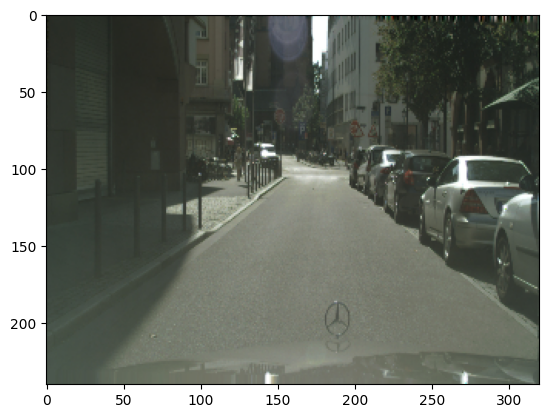

In [50]:
import cv2
img = cv2.imread(path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = tf.image.resize(img, imageSize, "bilinear").numpy().astype(np.int32)
plt.imshow(img)

In [51]:
areaPixels, (mask_pred * attetionArea).sum()

(17680, 17680)

In [52]:
mask_plt = maskToColor(mask)

mask_cut_plt = maskToColor(mask * attetionArea)
mask_pred_plt = maskToColor(mask_pred)
mask_pred_cut_plt = maskToColor(mask_pred * attetionArea)
#mask_pred_dist_plt = maskToColor(mask_pred * maskFar) + maskToColor(mask_pred * maskCloser)*200

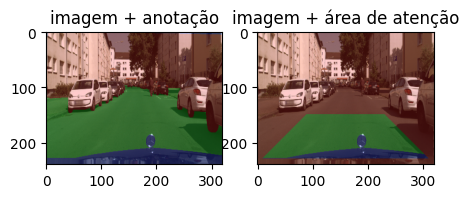

In [25]:
fig, axes = plt.subplots(
    nrows=1, ncols=2)
fig.set_figheight(2)
fig.set_figwidth(5)

axes[0].set_title("imagem + anotação")
axes[0].imshow(cv2.addWeighted(img, 0.8, mask_plt, 0.2, 0))
axes[1].set_title("imagem + área de atenção")
axes[1].imshow(cv2.addWeighted(img, 0.8, mask_cut_plt, 0.2, 0))
fig.savefig(f"metrics/exampleAttentionArea.png", format="png")

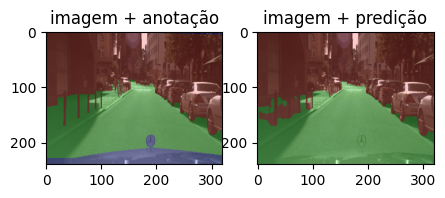

In [53]:
fig, axes = plt.subplots(
    nrows=1, ncols=2)
fig.set_figheight(2)
fig.set_figwidth(5)

axes[0].set_title("imagem + anotação")
axes[0].imshow(cv2.addWeighted(img, 0.8, mask_plt, 0.2, 0))
axes[1].set_title("imagem + predição")
axes[1].imshow(cv2.addWeighted(img, 0.8, mask_pred_plt, 0.2, 0))
axes[0].set_title("imagem + anotação")
axes[0].imshow(cv2.addWeighted(img, 0.8, mask_plt, 0.2, 0))
axes[1].set_title("imagem + predição")
axes[1].imshow(cv2.addWeighted(img, 0.8, mask_pred_plt, 0.2, 0))
fig.savefig(f"metrics/modelPrediction.png", format="png")

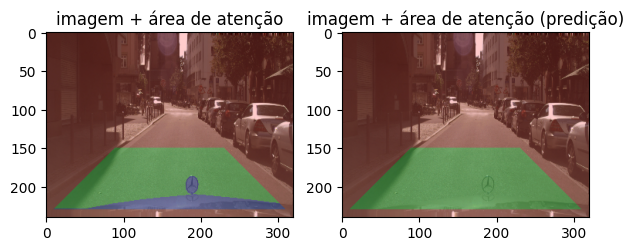

In [54]:
fig, axes = plt.subplots(
    nrows=1, ncols=2)
fig.set_figheight(2.5)
fig.set_figwidth(7)

axes[0].set_title("imagem + área de atenção")
axes[0].imshow(cv2.addWeighted(img, 0.8, mask_cut_plt, 0.2, 0))
axes[1].set_title("imagem + área de atenção (predição)")
axes[1].imshow(cv2.addWeighted(img, 0.8, mask_pred_cut_plt, 0.2, 0))
fig.savefig(f"metrics/modelAttentionArea.png", format="png")

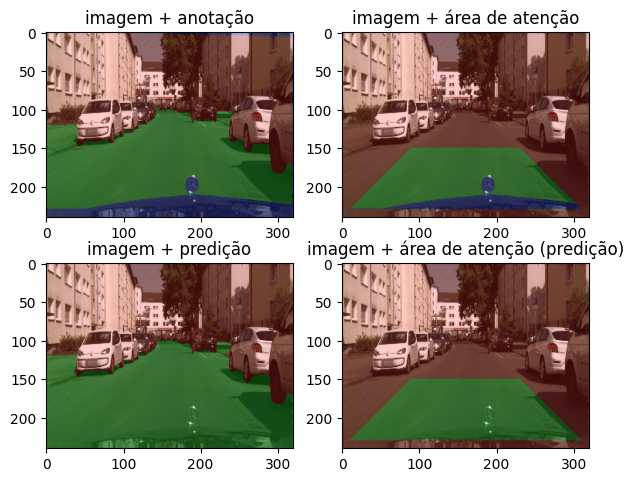

In [28]:
fig, axes = plt.subplots(
    nrows=2, ncols=2)
fig.set_figheight(5.5)
fig.set_figwidth(7)

axes[0, 0].set_title("imagem + anotação")
axes[0, 0].imshow(cv2.addWeighted(img, 0.8, mask_plt, 0.2, 0))
axes[0, 1].set_title("imagem + área de atenção")
axes[0, 1].imshow(cv2.addWeighted(img, 0.8, mask_cut_plt, 0.2, 0))
axes[1, 0].set_title("imagem + predição")
axes[1, 0].imshow(cv2.addWeighted(img, 0.8, mask_pred_plt, 0.2, 0))
axes[1, 1].set_title("imagem + área de atenção (predição)")
axes[1, 1].imshow(cv2.addWeighted(img, 0.8, mask_pred_cut_plt, 0.2, 0))
fig.savefig(f"metrics/modelAttentionArea.png", format="png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


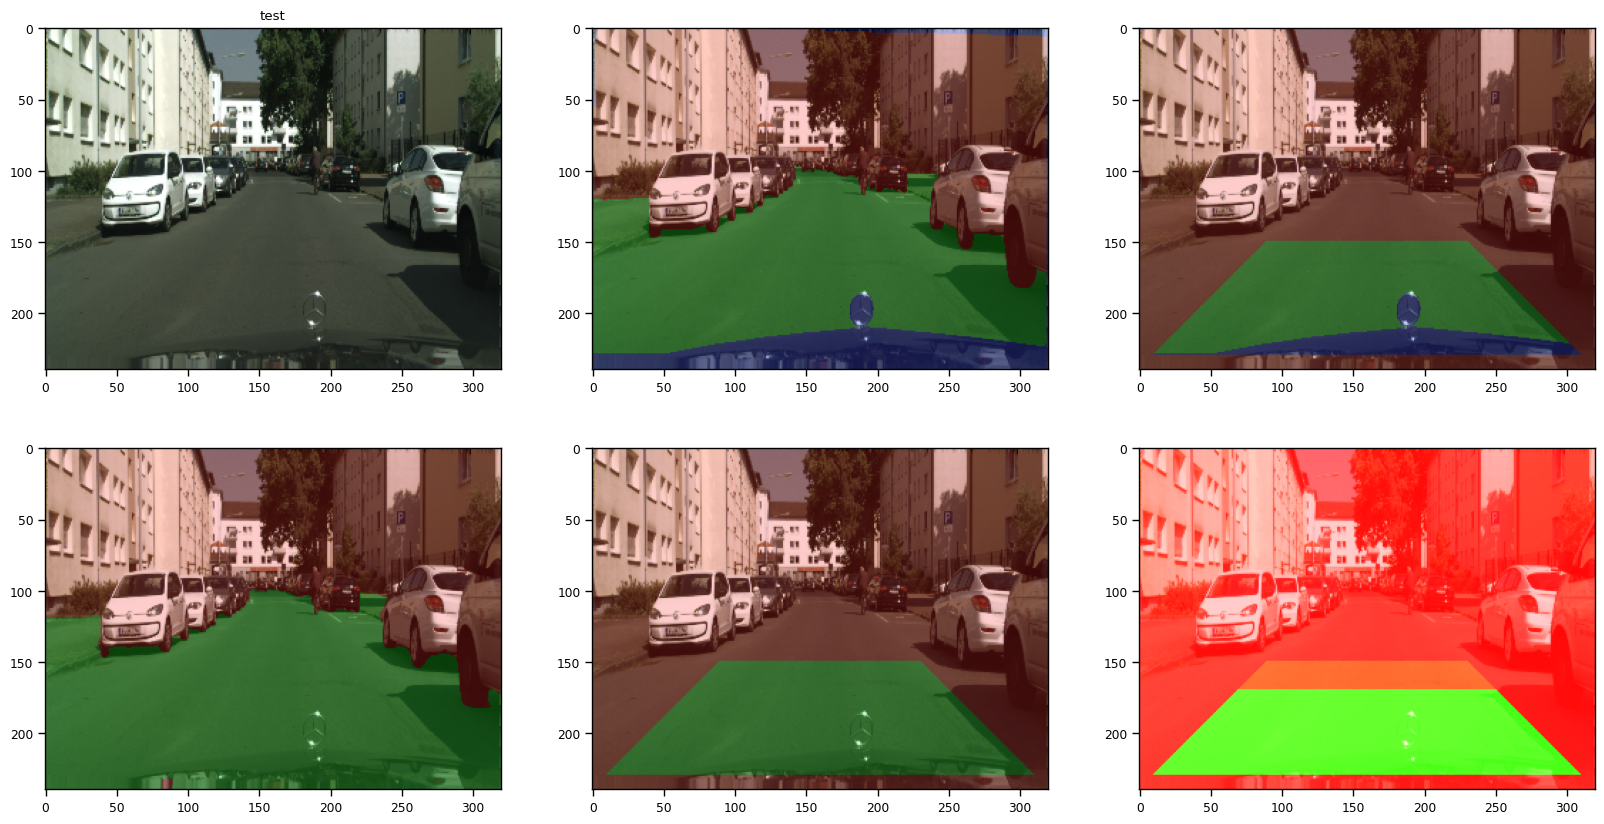

In [190]:
fig, axes = plt.subplots(
    nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(20)

axes[0, 0].set_title("Image")
axes[0, 0].imshow(img)
axes[0, 1].imshow(cv2.addWeighted(img, 0.8, mask_plt, 0.2, 0))
axes[0, 2].imshow(cv2.addWeighted(img, 0.8, mask_cut_plt, 0.2, 0))
axes[1, 0].imshow(cv2.addWeighted(img, 0.8, mask_pred_plt, 0.2, 0))
axes[1, 1].imshow(cv2.addWeighted(img, 0.8, mask_pred_cut_plt, 0.2, 0))
axes[1, 2].imshow(cv2.addWeighted(img, 0.8, mask_pred_dist_plt, 0.2, 0))

In [ ]:
matrix = run_confusion_matrix(model, test_data, normalize=False)
print(matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["False", "True"])
disp.plot()
disp.ax_.set(xlabel='Predicted', ylabel='Groundtruth')
plt.show()